<a href="https://colab.research.google.com/github/talhaanwarch/skin-disease-diagnosis/blob/master/Scenario_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/My\ Drive/isic_weights/isicall_eff3_weights.hdf5 /content/

In [3]:
%%capture
!pip install efficientnet

In [4]:
#download the dataset
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip

--2020-09-28 09:07:27--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.3
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.97.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3593344681 (3.3G) [application/octet-stream]
Saving to: ‘zr7vgbcyr2-1.zip’

zr7vgbcyr2-1.zip    100%[===================>]   3.35G  21.9MB/s    in 2m 39s  

2020-09-28 09:10:06 (21.6 MB/s) - ‘zr7vgbcyr2-1.zip’ saved [3593344681/3593344681]



In [5]:
#unzip the dataset
%%capture
!unzip zr7vgbcyr2-1.zip

In [6]:
#create a new folder named as data
!mkdir data

In [7]:
#unzip all subfolder
%%capture
!unzip /content/images/imgs_part_1.zip
!unzip /content/images/imgs_part_2.zip
!unzip /content/images/imgs_part_3.zip

In [8]:
#move all pictures from subfolder to main folder data
!mv  /content/imgs_part_1/* /content/data
!mv  /content/imgs_part_2/* /content/data
!mv  /content/imgs_part_3/* /content/data

In [9]:
#remove the folder that contain subfolders
!rm -r /content/images

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#read annotation file
df=pd.read_csv('/content/metadata.csv')
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [11]:
#create a dataframe with image name and encoded labels
labels=pd.get_dummies(df['diagnostic'])
df=pd.concat([df['img_id'],labels],axis=1)
df.head()
#MEL	NV	BCC	AK	BKL		SCC

,img_id,ACK,BCC,MEL,NEV,SCC,SEK
0,PAT_1516_1765_530.png,0,0,0,1,0,0
1,PAT_46_881_939.png,0,1,0,0,0,0
2,PAT_1545_1867_547.png,1,0,0,0,0,0
3,PAT_1989_4061_934.png,1,0,0,0,0,0
4,PAT_684_1302_588.png,0,1,0,0,0,0


In [12]:
#shuffle the dataframe
df=df.sample(frac=1)
df.head()

,img_id,ACK,BCC,MEL,NEV,SCC,SEK
2078,PAT_388_4500_103.png,1,0,0,0,0,0
315,PAT_831_1570_991.png,1,0,0,0,0,0
659,PAT_529_994_419.png,0,1,0,0,0,0
1132,PAT_1807_3481_801.png,1,0,0,0,0,0
1066,PAT_269_415_103.png,0,1,0,0,0,0


In [13]:
#labels columns in dataframe
col=list(df.columns)[1::]
col

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

In [14]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest')

In [15]:
# model hyperparameters
img_shape=300
batch_size=20
n_epochs=20

In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [17]:
#first create the pretrained model and load weights


In [18]:
def basemodel():
  import efficientnet.tfkeras as efn
  pre_trained_model =efn.EfficientNetB3(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))
  x = pre_trained_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation="relu")(x)
  predictions = Dense(8, activation="softmax")(x) #pretrained model has 7 classes
  pre_trained_model = Model(inputs=pre_trained_model.input, outputs=predictions)
  pre_trained_model.load_weights('/content/isicall_eff3_weights.hdf5') #load pretrained weights to to model
  #now remove all added layers in pretrained layers add new leayer and create base model
  #here we can test how many layers we want to remove
  base_model = Model(pre_trained_model.input, pre_trained_model.layers[-7].output)
  #now add our new layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128,name='dense1', activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64,name='dense2', activation="relu")(x)

  predictions  = Dense(len(col),name='output', activation="softmax")(x) #base model has six layers
  base_model = Model(inputs=base_model.input, outputs=predictions )
  #compile the base model
  base_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return base_model

In [19]:

from sklearn.model_selection import KFold,StratifiedKFold
import gc

from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,balanced_accuracy_score
classification_reports=[]
kf = KFold(n_splits=5,shuffle=True)
history=[]
accuracy=[]
f1_scores=[]
auc=[]
y_pred=[]
precision=[]
recall=[]
balanced_acc=[]
fold=0
for train_index, test_index in kf.split(df):
  train=df.iloc[train_index,:]
  val=df.iloc[test_index,:]
  print('-----------fold {}--------------'.format(fold))
  train_generator=data_gen.flow_from_dataframe(train,directory='/content/data',
                                               target_size=(img_shape,img_shape),
                                               x_col='img_id',
                                               y_col=col,
                                               class_mode='raw',
                                               shuffle=True,
                                               batch_size=batch_size)

  val_generator=data_gen.flow_from_dataframe(val,directory='/content/data',
                                             target_size=(img_shape,img_shape),
                                             x_col="img_id",
                                             y_col=col,
                                             class_mode='raw',
                                             shuffle=False,
                                             batch_size=batch_size)
  #train_generator.next()[0].shape,train_generator.next()[1].shape

  #load base model
  base_model=basemodel()
  #train model
  results = base_model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.000001),
                                         #ModelCheckpoint('model_{}.hdf5'.format(fold), save_best_only=True, monitor='val_loss', mode='min')
                                         ])
  #model.load_weights('model_{}.hdf5'.format(fold))
  val_generator.reset()
  y_pred=base_model.predict(val_generator,steps=val_generator.n/batch_size,verbose=0)
  y_pred=y_pred.round().astype(int)
  y_true=val.iloc[:,1::]

  f1=f1_score(y_true,y_pred,average='macro',labels=np.unique(y_pred))
  print('f1 score is ', f1)

  accuracy.append(accuracy_score(y_true,y_pred))
  auc.append(roc_auc_score(y_true,y_pred))
  precision.append(precision_score(y_true,y_pred,average='macro',labels=np.unique(y_pred)))
  recall.append(recall_score(y_true,y_pred,average='macro',labels=np.unique(y_pred)))
  balanced_acc.append(balanced_accuracy_score(y_true.values.argmax(axis=1), y_pred.argmax(axis=1)))

  f1_scores.append(f1)
  history.append(results)
  fold+=1

  del base_model
  K.clear_session()
  gc.collect()

-----------fold 0--------------
Found 1838 validated image filenames.
Found 460 validated image filenames.
f1 score is  0.8070011127596439
-----------fold 1--------------
Found 1838 validated image filenames.
Found 460 validated image filenames.
f1 score is  0.7678571428571428
-----------fold 2--------------
Found 1838 validated image filenames.
Found 460 validated image filenames.
f1 score is  0.7674404323262097
-----------fold 3--------------
Found 1839 validated image filenames.
Found 459 validated image filenames.
f1 score is  0.8013578512311936
-----------fold 4--------------
Found 1839 validated image filenames.
Found 459 validated image filenames.
f1 score is  0.8196036486922829


In [20]:
#average accuracy across all folds
np.mean(accuracy)

0.74195699535853

In [21]:
#average f1_scores across all folds
np.mean(f1_scores)

0.7926520375732945

In [22]:
#average auc_scores across all folds
np.mean(auc)

0.8082275839823829

In [23]:
np.mean(balanced_acc)

0.6719192036037243

In [24]:
np.mean(precision)

0.7958815719313675

In [25]:
np.mean(recall)

0.7900509784261175

In [26]:

history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [27]:

def plot_accuracy(hist,acc='val_accuracy'):
    for i in range(5):
      plt.plot(hist[i].history[acc],linestyle='-.',linewidth=1.5)
     
    mean=np.mean([[j for j in x.history[acc]] for x in hist],axis=0)
    std=np.std([[j for j in x.history[acc]] for x in hist],axis=0)
    plt.plot(mean,linewidth=2,color='black')
    if acc=='val_accuracy':
      plt.title('Model Validation Accuracy')
    else:
      plt.title('Model Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Fold1','Fold2','Fold3','Fold4','Fold5','Average Val Accuracy' ], loc='best')
    plt.show()

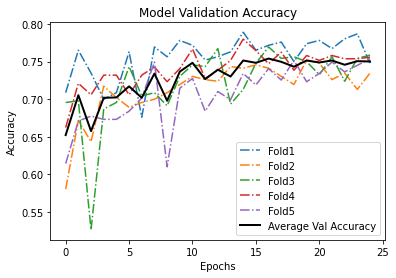

In [28]:
plot_accuracy(history)

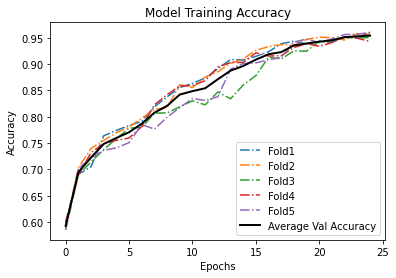

In [29]:
plot_accuracy(history,acc='accuracy')